## Necessary Imports

In [1]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn import feature_selection
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Loading the training file

In [2]:
data_raw = pd.read_csv('training.psv', sep='|', header=0)
train_df = data_raw.copy(deep = True)
train_df1 = data_raw.copy(deep = True)

In [3]:
train_df.head()

,student_id,level,course,grade,major
0,ppVGBRKhtqqyxnVO,Freshman,SPAN:100,A,Business
1,PiPkSgMGbFIu5RwR,Freshman,CSI:160,S,International Relations
2,PiPkSgMGbFIu5RwR,Sophomore,EES:107,C,International Relations
3,PiPkSgMGbFIu5RwR,Senior,SPAN:201,B,International Relations
4,PiPkSgMGbFIu5RwR,Junior,ENTR:200,B+,International Relations


In [4]:
train_df.describe()

,student_id,level,course,grade,major
count,97276,97276,97276,97276,97276
unique,10000,4,2721,21,81
top,cJdq8OlOg2x4drwW,Senior,RHET:103,A,Psychology
freq,90,30367,1685,18729,10274


### Total No. of Grades ----> Problem PDF has 20 explicitly stated grades,
But our Grades our coming 21 unique
### This is noise
### There are total 2721(A lot) number of courses
### Final prediction ----> 81 Majors Possible(Lot of output classes)

In [5]:
train_df.grade.unique()

array(['A', 'S', 'C', 'B', 'B+', 'D+', 'A-', 'C+', 'B-', 'D', 'A+', 'C-',
       'R', 'AUS', 'D-', 'I', 'P', 'U', 'WX', 'AUU', 'N'], dtype=object)

#### I am assuming that all grades written 'I' were actually 'IP' and were accidentally stored this way! 

In [6]:
train_df = train_df[~train_df.grade.str.contains('WX')]
train_df = train_df[~train_df.grade.str.contains('R')]

### Encoding grades to integers

In [7]:
grade = {"A+" : 20,"A" : 19,"A-" : 18,"B+" : 17,"B" : 16,"B-" : 15,"C+" : 14,
         "C" : 13,"C-" : 12,"D+" : 11,"D" : 10,"D-" : 9,"F" : 8,
        "AUS" : 7,"AUU" : 6,"I" : 5,"N" : 4,"P" : 3,"S" : 2,"U" : 1}
train_df['grade'] = train_df['grade'].map(grade)

### Encoding the 4 unique levels into integers

In [8]:
levels = {"Freshman": 0, "Sophomore": 1, "Junior": 2, "Senior": 3}
train_df['level'] = train_df['level'].map(levels)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# course_count = train_df['course'].value_counts()
# sns.set(style="darkgrid")
# sns.barplot(course_count.index, course_count.values, alpha=0.9)
# plt.title('Frequency Distribution of Courses')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Courses', fontsize=12)
# plt.show()


Now Since we have levels seperately, for each course, it doesn't make sense to make dummy for 2500+ courses leading into a very sparse representation of features.
This is because of various subject_ids of subjects.
Since it won't make sense that way, I will seperate each coloumn entry of courses by splitting the term given after : and using only the subject and not the subject_id
ex-> CSC:142 and CSC :421 are only different in terms of level or ids, we will convert both of these into CSC

In [11]:
df1 = train_df['course'].str.split(":",expand = True)
train_df['course'] = df1[0]
len(train_df.course.unique())

179

Narrowed down from 2721unique courses to 179 unique courses, using only the course split up

### Now, Converting the major(Output variable/To Be Predicted) into random integer encoding so that we can try varous models on this

In [12]:
revert1 = dict([(code,category) for code, category in enumerate(train_df1.major.astype('category').cat.categories)])
train_df['major'] = train_df['major'].astype('category').cat.codes
train_df.head()

,student_id,level,course,grade,major
0,ppVGBRKhtqqyxnVO,0,SPAN,19,11
1,PiPkSgMGbFIu5RwR,0,CSI,2,45
2,PiPkSgMGbFIu5RwR,1,EES,13,45
3,PiPkSgMGbFIu5RwR,3,SPAN,16,45
4,PiPkSgMGbFIu5RwR,2,ENTR,17,45


### We need to store this mapping so that we can revert back our predictions back to the actual mapping, so we used this dictionary called revert1

In [13]:
revert1

{0: 'Accounting',
 1: 'Actuarial Science',
 2: 'Actuarial Sciences',
 3: 'African American Studies',
 4: 'Anthropology',
 5: 'Art',
 6: 'Asian Studies',
 7: 'Astronomy',
 8: 'Biochemistry',
 9: 'Biology',
 10: 'Biomedical Sciences',
 11: 'Business',
 12: 'Business Administration',
 13: 'Business Analytics',
 14: 'Chemical Engineering',
 15: 'Chemistry',
 16: 'Chiropractic',
 17: 'Cinema',
 18: 'Civil Engineering',
 19: 'Classical Languages',
 20: 'Communication Studies',
 21: 'Computer Science',
 22: 'Criminology',
 23: 'Dance',
 24: 'Dentistry',
 25: 'Economics',
 26: 'Education',
 27: 'Electrical Engineering',
 28: 'English',
 29: 'Environmental Sciences',
 30: 'Ethics And Public Policy',
 31: 'Finance',
 32: 'French',
 33: 'Gender Studies',
 34: 'Geography',
 35: 'German',
 36: 'Global Studies',
 37: 'Health And Sport Sciences',
 38: 'Health And Sport Studies',
 39: 'History',
 40: 'Human Physiology',
 41: 'Industrial Engineering',
 42: 'Informatics',
 43: 'Interdepartmental Studies

### Trying out methods to do grouping below(Ignore the below cell)

In [14]:
# import numpy as np
# import pandas as pd

# tata = train_df.groupby('student_id').course.value_counts()
# # train_df1 = grouped.agg({'grade' : np.sum,
# #                 'level' : np.mean,
# #              'major': np.mean ,
# #             'course' : np.max,
# # #             })
# favcourse = train_df.groupby("student_id").course.()
# favcourse
# topdf['01W7KB8TDNWNx4YW'].PSY
# tata

In [15]:
train_course_df = train_df
train_df.shape

(96272, 5)

In [16]:
train_df.head()

,student_id,level,course,grade,major
0,ppVGBRKhtqqyxnVO,0,SPAN,19,11
1,PiPkSgMGbFIu5RwR,0,CSI,2,45
2,PiPkSgMGbFIu5RwR,1,EES,13,45
3,PiPkSgMGbFIu5RwR,3,SPAN,16,45
4,PiPkSgMGbFIu5RwR,2,ENTR,17,45


## Now, for every student, they have certain courses they took using some level of each course and grades they got in the courses(Converted to integer mapping). We will now group each student by its unique id
### This leads us to various parts of aggregation that I performed
# I felt the two most important criteria that we need to keep for each student while aggregating is : Course for which they had highest frequency (Most frequent course they took), frequency of their course, (so that out model includes impact of taking a particular course a particular time), average, sum and number of grades given

In [17]:
aggregations = {
    'grade': { # work on the "duration" column
        'grade_sum': 'sum',  # get the sum, and call this result 'total_duration'
        'grade_mean': 'mean', # get mean, call result 'average_duration'
        'grade_count': 'count'
    },
    'level' : {'level' : 'mean'},
    'major' : {'major' : 'mean'},
#     'course': ["count", "max"]  # Calculate two results for the 'network' column with a list
}

# Perform groupby aggregation by "month", but only on the rows that are of type "call"
train_df = train_df.groupby('student_id',as_index=False).agg(aggregations)
train_df.head()

student_id     grade                            level major
                    grade_sum grade_mean grade_count     level major
0  01DiJuoJAB395ucJ        16  16.000000           1  3.000000    13
1  01MhxeQl5FhRsf3f        13  13.000000           1  0.000000    11
2  01W7KB8TDNWNx4YW       197  15.153846          13  1.923077    67
3  042Rmpv5B2kXdfBR        15  15.000000           1  2.000000    20
4  04DuzbneGqk0o0jY        17  17.000000           1  1.000000    29

## For every unique student, Now I have evaluated the most frequent course they took (favcourse) and its frequency(freq_fc)

In [18]:
def get_top_course(g):
    return g['course'].value_counts().idxmax() 
def get_top_course_freq(g):
    return g['course'].value_counts().max() 
# topdf = train_df.groupby('student_id').course.value_counts()
topdf = train_course_df.groupby('student_id',as_index=False).apply(get_top_course)
topdf1 = train_course_df.groupby('student_id',as_index=False).apply(get_top_course_freq)


type(topdf.values)
coloumns = ['favcourse']
coloumns1 = ['freq_fc']

df5 = pd.DataFrame(topdf,columns=coloumns)
df4 = pd.DataFrame(topdf1,columns=coloumns1)

train_df['freq_fc'] = df4['freq_fc']
train_df['favcourse'] = df5['favcourse']

In [19]:
train_df.head()
# train_df.describe()

student_id     grade                            level major freq_fc  \
                    grade_sum grade_mean grade_count     level major           
0  01DiJuoJAB395ucJ        16  16.000000           1  3.000000    13       1   
1  01MhxeQl5FhRsf3f        13  13.000000           1  0.000000    11       1   
2  01W7KB8TDNWNx4YW       197  15.153846          13  1.923077    67       5   
3  042Rmpv5B2kXdfBR        15  15.000000           1  2.000000    20       1   
4  04DuzbneGqk0o0jY        17  17.000000           1  1.000000    29       1   

  favcourse  
             
0      MSCI  
1      SPAN  
2       PSY  
3      POLI  
4      STAT

### Resetting MultiIndex dataframe and falttening it

In [20]:
train_df.columns = [f'{s}' if s != '' else f'{f}' 
              for f, s in train_df.columns]

train_df.head()


,student_id,grade_sum,grade_mean,grade_count,level,major,freq_fc,favcourse
0,01DiJuoJAB395ucJ,16,16.000000,1,3.000000,13,1,MSCI
1,01MhxeQl5FhRsf3f,13,13.000000,1,0.000000,11,1,SPAN
2,01W7KB8TDNWNx4YW,197,15.153846,13,1.923077,67,5,PSY
3,042Rmpv5B2kXdfBR,15,15.000000,1,2.000000,20,1,POLI
4,04DuzbneGqk0o0jY,17,17.000000,1,1.000000,29,1,STAT


## To check if our data has any null/NaN value or any missing value

In [21]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
favcourse,0,0.0
freq_fc,0,0.0
major,0,0.0
level,0,0.0
grade_count,0,0.0


In [22]:
# train_df['freq'] = train_df.groupby('student_id').transform(
#     lambda x: x.course.sum()
# )
# train_df.head()

## Now since we have course that was taken most frequently , this is the only nominal attribute that we have.
I encoded these using similar method into random integers.

In [23]:
revert = dict([(code,category) for code, category in enumerate(train_df.favcourse.astype('category').cat.categories)])
train_df['favcourse'] = train_df['favcourse'].astype('category').cat.codes

In [24]:
revert

{0: 'ACCT',
 1: 'ACTS',
 2: 'AERO',
 3: 'AFAM',
 4: 'AINS',
 5: 'AMST',
 6: 'ANTH',
 7: 'ARAB',
 8: 'ARTH',
 9: 'ARTS',
 10: 'ASIA',
 11: 'ASL',
 12: 'ASP',
 13: 'ASTR',
 14: 'ATEP',
 15: 'BIOC',
 16: 'BIOL',
 17: 'BUS',
 18: 'CBE',
 19: 'CCP',
 20: 'CEE',
 21: 'CERM',
 22: 'CHEM',
 23: 'CHIN',
 24: 'CINE',
 25: 'CLSA',
 26: 'CLSL',
 27: 'CNW',
 28: 'COMM',
 29: 'CPH',
 30: 'CRIM',
 31: 'CS',
 32: 'CSD',
 33: 'CSI',
 34: 'CW',
 35: 'DANC',
 36: 'DPA',
 37: 'DST',
 38: 'ECE',
 39: 'ECON',
 40: 'EDTL',
 41: 'EES',
 42: 'ENGL',
 43: 'ENGR',
 44: 'ENTR',
 45: 'ESL',
 46: 'FIN',
 47: 'FREN',
 48: 'FYP',
 49: 'GEOG',
 50: 'GHS',
 51: 'GRMN',
 52: 'GWSS',
 53: 'HHP',
 54: 'HIST',
 55: 'HONR',
 56: 'HPAS',
 57: 'IBA',
 58: 'IE',
 59: 'IIEP',
 60: 'IS',
 61: 'ITAL',
 62: 'JMC',
 63: 'JPNS',
 64: 'LAS',
 65: 'LEIS',
 66: 'LING',
 67: 'LLS',
 68: 'LS',
 69: 'MATH',
 70: 'MGMT',
 71: 'MICR',
 72: 'MILS',
 73: 'MKTG',
 74: 'MSCI',
 75: 'MUS',
 76: 'MUSM',
 77: 'NURS',
 78: 'PCOL',
 79: 'PHIL',
 80:

### Since I feel that this is the point where I have collected all my features, I applie chiSquare test to verify if these featues are correlated to my output variable or not

In [25]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)


#Initialize ChiSquare Class
cT = ChiSquare(train_df)
# train_df.columns
# Feature Selection
testColumns = ['favcourse', 'freq_fc', 'grade_sum','grade_mean','grade_count','level']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="major" ) 

favcourse is IMPORTANT for Prediction
freq_fc is IMPORTANT for Prediction
grade_sum is IMPORTANT for Prediction
grade_mean is IMPORTANT for Prediction
grade_count is IMPORTANT for Prediction
level is IMPORTANT for Prediction


## So all the features seem to be important for predicting our output!
Let's check if they are related to one another 

In [26]:
correlated_features = set()  
correlation_matrix = train_df.corr()  
for i in range(len(correlation_matrix .columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
(correlated_features)

{'grade_count'}

In [27]:
correlation_matrix
train_df = train_df.drop('grade_count',axis = 1)
train_df.head()

,student_id,grade_sum,grade_mean,level,major,freq_fc,favcourse
0,01DiJuoJAB395ucJ,16,16.000000,3.000000,13,1,74
1,01MhxeQl5FhRsf3f,13,13.000000,0.000000,11,1,96
2,01W7KB8TDNWNx4YW,197,15.153846,1.923077,67,5,83
3,042Rmpv5B2kXdfBR,15,15.000000,2.000000,20,1,81
4,04DuzbneGqk0o0jY,17,17.000000,1.000000,29,1,100


In [28]:
train_df.head()

,student_id,grade_sum,grade_mean,level,major,freq_fc,favcourse
0,01DiJuoJAB395ucJ,16,16.000000,3.000000,13,1,74
1,01MhxeQl5FhRsf3f,13,13.000000,0.000000,11,1,96
2,01W7KB8TDNWNx4YW,197,15.153846,1.923077,67,5,83
3,042Rmpv5B2kXdfBR,15,15.000000,2.000000,20,1,81
4,04DuzbneGqk0o0jY,17,17.000000,1.000000,29,1,100


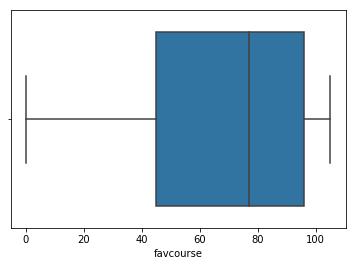

In [29]:
import seaborn as sns
sns.boxplot(x=train_df['favcourse'])

In [30]:
train_df['major'].describe()

count    9991.000000
mean       32.394255
std        21.031308
min         0.000000
25%        11.000000
50%        28.000000
75%        52.000000
max        79.000000
Name: major, dtype: float64

## Now we simply split our overall data into training and testing so that we will be able to evaluate our models.
### Importantly, we need to drop student_id and major from our features set and our prediction must only contain our encoded majors

In [31]:
train_df.head()
#train_df = train_df.drop('student_id',axis=1)
df_train, df_test = train_test_split(train_df, test_size=0.2,stratify=train_df['major'].values>40)
df_train, df_valid = train_test_split(df_train, test_size=0.33)
X_test = df_test.drop('major',axis = 1)
X_train = df_train.drop('major',axis=1)


X_train = X_train.drop('student_id',axis=1)

X_test = X_test.drop('student_id',axis = 1)

Y_train =  df_train['major']
Y_test = df_test['major']

In [32]:
df_valid.head()
Y_valid = df_valid['major']
X_valid = df_valid.drop('student_id',axis=1)
X_valid = X_valid.drop('major',axis=1)

In [33]:
X_train.head()

,grade_sum,grade_mean,level,freq_fc,favcourse
4937,223,18.583333,2.416667,6,90
3170,246,14.470588,1.411765,3,81
3479,60,15.000000,2.000000,1,11
5574,227,13.352941,1.823529,3,65
4692,385,12.833333,2.266667,8,95


In [34]:
Y_train.head()

4937    69
3170    39
3479    65
5574    48
4692    73
Name: major, dtype: int8

### Trying out all models one by one

### KNN Classifier with 1 neighbour

In [35]:
neigh = KNeighborsClassifier(n_neighbors=1)
nfit = neigh.fit(X_train, Y_train)
result1 = nfit.predict(X_test)
accuracy_score(Y_test, result1)

0.6833416708354177

### KNN Classifier with 10 neighbours

In [36]:
neigh = KNeighborsClassifier(n_neighbors=1)
nfit = neigh.fit(X_train, Y_train)
result1 = nfit.predict(X_test)
accuracy_score(Y_test, result1)

0.6833416708354177

### RadiusNeighborsClassifier

In [37]:
from sklearn.neighbors import RadiusNeighborsClassifier
rneigh = RadiusNeighborsClassifier(radius=5,outlier_label = 1134)
rneigh.fit(X_train, Y_train)
rnc_pred = rneigh.predict(X_test)
accuracy_score(Y_test, rnc_pred)

0.5142571285642822

### Decision Tree with validation split

In [38]:
# cv_split = model_selection.ShuffleSplit(n_splits = 1000, test_size = .2, train_size = .6, random_state = 0)
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, X_train, Y_train, cv  = 5)
dtree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [39]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
y3_pred = dtree.predict(X_test)
accuracy_score(Y_test,y3_pred)

0.8549274637318659

### Cross Validated Score for decision tree to check overfitting

In [40]:
from sklearn import metrics
scores = cross_val_score(dtree, X_train, Y_train, cv=10)
print ("Crossvalidated scores:", scores)

Crossvalidated scores: [0.84320557 0.85035211 0.84050179 0.83484574 0.87060998 0.85768501
 0.86486486 0.86132812 0.86166008 0.88577154]


### (Uncomment the cell below for: ) Visualizing the tree

In [41]:
# import graphviz 
# dot_data = tree.export_graphviz(dtree, out_file=None, 
#                                 feature_names = X_test.columns, class_names = True,
#                                 filled = True, rounded = True)
# graph = graphviz.Source(dot_data) 
# graph

In [42]:
# prob = dtree.predict_proba(X_test)
# arr = []
# for i in range(len(Y_test)):
#     arr.append(prob[i].argsort()[-3:][::-1])
# df_ans = pd.DataFrame()
# df_ans['pred'] = arr
# df1 = pd.DataFrame(df_ans.pred.tolist(), columns=['major1', 'major2','major3'])
# df1.replace(revert1.keys(),revert1.values())

### The decision tree though giving better accuracy than above mentioned classifiers, 
### But for some of the instances,
#### it gives only 1 best major with 1(highest probablity) and takes 2 other majors whose probablity is very close to 0

In [43]:
# classprob1 = dtree.predict_proba(Xt_test)
# arr = []
# for i in range(len(Xt_test)):
#     arr.append(classprob1[i].argsort()[-3:][::-1])
# df_answer = pd.DataFrame()
# df_answer['pred'] = arr
# dftestans = pd.DataFrame(df_answer.pred.tolist(), columns=['major1', 'major2','major3'])
# dftestans = dftestans.replace(revert1.keys(),revert1.values())
# dftestans.describe()
# test_df.columns = grouped.columns.droplevel(level=0)

### Adaboost

In [44]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

bdt_real = AdaBoostClassifier(DecisionTreeClassifier(random_state = 0),n_estimators=2000,learning_rate=0.5)
bdt_real.fit(X_train, Y_train)
real_test_predict = bdt_real.predict(X_test)
accuracy_score(real_test_predict, Y_test)

0.8619309654827414

In [45]:
# classprob1
# classprob1[0]

## Random Forest(To be compared)

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=1)
forest.fit(X_train, Y_train)
rf_pred = forest.predict(X_test)
accuracy_score(Y_test, rf_pred)


0.848424212106053

In [47]:
# len(Y_train.unique())

In [48]:
# classprob2 = forest.predict_proba(Xt_test)
# arr = []
# for i in range(len(Xt_test)):
#     arr.append(classprob2[i].argsort()[-3:][::-1])
# df_answer1 = pd.DataFrame()
# df_answer1['pred'] = arr
# dftestans1 = pd.DataFrame(df_answer1.pred.tolist(), columns=['major1', 'major2','major3'])
# dftestans1 = dftestans1.replace(revert1.keys(),revert1.values())
# dftestans1.describe()

# len(classprob2[3])

### Ababoost with max_depth 7 (FINAL ANSWER)

In [49]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

bdt_real_depth = AdaBoostClassifier(DecisionTreeClassifier(random_state = 0,max_depth = 7),n_estimators=1000,learning_rate=0.5)
bdt_real_depth.fit(X_train, Y_train)
real_test_predict = bdt_real_depth.predict(X_test)
accuracy_score(real_test_predict, Y_test)

0.8074037018509255

In [50]:
# classprob3 = bdt_real_depth.predict_proba(Xt_test)
# arr = []
# for i in range(len(Xt_test)):
#     arr.append(classprob3[i].argsort()[-3:][::-1])
# df_answer2 = pd.DataFrame()
# df_answer2['pred'] = arr
# dftestans2 = pd.DataFrame(df_answer2.pred.tolist(), columns=['major1', 'major2','major3'])
# dftestans2 = dftestans2.replace(revert1.keys(),revert1.values())
# dftestans2.describe()

In [51]:
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

# clf.fit(X, y)
# classprob3[0]

MLP CLassifier

In [52]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
St_train = scaler.transform(X_train)  
# apply same transformation to test data
St_test = scaler.transform(X_test)  

C:\Users\Kartik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kartik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\Kartik\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [53]:
from sklearn.neural_network import MLPClassifier
mlpnn = MLPClassifier(solver='lbfgs', alpha=1e-5,random_state=1)
mlpnn.fit(St_train, Y_train)
mlp_pred = mlpnn.predict(St_test)
accuracy_score(mlp_pred, Y_test)

0.7933966983491746

### After evaluating all of these models, I am selecting Adaboost as the best model as it has highest validation accuracy and should perform best on unseen data.

### Loading the actual test dataset

In [54]:
file2 = pd.read_csv('eval.psv', sep='|', header=0)
test_df = file2.copy(deep = True)
test_df = test_df.drop('major1',axis = 1)
test_df = test_df.drop('major2',axis = 1)
test_df = test_df.drop('major3',axis = 1)
testFinal_df = test_df.copy(deep = True)
test_df = test_df[~test_df.grade.str.contains('WX')]
test_df = test_df[~test_df.grade.str.contains('R')]
test_df['level'] = test_df['level'].map(levels)
test_df['grade'] = test_df['grade'].map(grade)
df2 = test_df['course'].str.split(":",expand = True)
test_df['course'] = df2[0]
test_course_df = test_df

### Performing preprocessing on test data 

In [55]:
test_df['major'] = 0
test_df = test_df.groupby('student_id',as_index=False).agg(aggregations)
file2.head()
test_df.head()


toptestdf = test_course_df.groupby('student_id',as_index=False).apply(get_top_course)
toptestdf1 = test_course_df.groupby('student_id',as_index=False).apply(get_top_course_freq)


# type(toptestdf.values)
test_coloumns = ['favcourse']
test_coloumns1 = ['freq_fc']

dftestfav = pd.DataFrame(toptestdf,columns=test_coloumns)
dftestfreq = pd.DataFrame(toptestdf1,columns=test_coloumns1)

test_df['freq_fc'] = dftestfreq['freq_fc']
test_df['favcourse'] = dftestfav['favcourse']
test_df.columns = [f'{s}' if s != '' else f'{f}' 
              for f, s in test_df.columns]

test_df.head()
studentcopy = test_df['student_id']
studentcopy.head()
Xt_test = test_df.drop('major',axis = 1)
Xt_test = Xt_test.drop('grade_count',axis = 1)
Xt_test = Xt_test.drop('student_id',axis = 1)
list(Xt_test)
Xt_test['favcourse'] = Xt_test['favcourse'].astype('category').cat.codes
Xt_test.head()

,grade_sum,grade_mean,level,freq_fc,favcourse
0,19,19.000000,1.000000,1,39
1,14,14.000000,1.000000,1,79
2,16,16.000000,2.000000,1,56
3,255,14.166667,2.333333,4,34
4,244,12.842105,1.736842,5,22


## Predicting class probablities and final 3 majors on test data

In [56]:
classprob1 = bdt_real.predict_proba(Xt_test)
arr = []
for i in range(len(Xt_test)):
    arr.append(classprob1[i].argsort()[-3:][::-1])
df_answer = pd.DataFrame()
df_answer['pred'] = arr
dftestans = pd.DataFrame(df_answer.pred.tolist(), columns=['major1', 'major2','major3'])
dftestans = dftestans.replace(revert1.keys(),revert1.values())
dftestans.describe()
dftestans['student_id'] = studentcopy
dftestans.head()

,major1,major2,major3,student_id
0,Health And Sport Sciences,Religion,Art,01BVNwmXUXsoVHLd
1,Radiation Sciences,Communication Studies,Asian Studies,03TWkCsakXIVrOtA
2,Human Physiology,Geography,Chiropractic,067YeH4Acv00Bdvf
3,Economics,Informatics,Dance,06TWQIIh4SaEAnOu
4,Chemistry,Biochemistry,Biology,08dMDGiuTXbojMV0


### Merging and writing the output to final eval.psv file

In [57]:
import pandas as pd
answer = pd.merge(testFinal_df,dftestans, on='student_id', how='inner')
answer

,student_id,level,course,grade,major1,major2,major3
0,6Q79FVMSbTPMBhha,Senior,ECE:489,A,Cinema,Biology,Russian
1,6Q79FVMSbTPMBhha,Sophomore,MATH:246,B,Cinema,Biology,Russian
2,6Q79FVMSbTPMBhha,Sophomore,ECE:344,C+,Cinema,Biology,Russian
3,6Q79FVMSbTPMBhha,Junior,ARTS:280,B,Cinema,Biology,Russian
4,6Q79FVMSbTPMBhha,Freshman,CSI:160,AUS,Cinema,Biology,Russian
5,6Q79FVMSbTPMBhha,Junior,ECE:336,A-,Cinema,Biology,Russian
6,6Q79FVMSbTPMBhha,Junior,ECE:332,B+,Cinema,Biology,Russian
7,6Q79FVMSbTPMBhha,Senior,CS:370,A-,Cinema,Biology,Russian
8,6Q79FVMSbTPMBhha,Sophomore,LS:101,S,Cinema,Biology,Russian
9,6Q79FVMSbTPMBhha,Freshman,ARTH:106,B-,Cinema,Biology,Russian


In [58]:
answer.to_csv("adaboost.csv", index = None, header=True, encoding='utf-8',sep = '|')

In [59]:
import os
os.rename('adaboost.csv','eval1.psv')

In [60]:
fileRead = pd.read_csv('eval1.psv', sep='|', header=0)